In [4]:
#!pip install keras

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras

# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout



In [48]:
#Image handling libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

In [6]:
#Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
#Initialize a list of paths for images
imagepaths = []

import os
for dirname, _, filenames in os.walk('leapGestRecog'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))
        if path.endswith("png"):
            imagepaths.append(path)

print(len(imagepaths))

40000


In [8]:
#Defining a function that plots the image selected from a path

def img_plot(img_path):
    img = cv2.imread(img_path)
    #convert to RGB space
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #check the shape of the image
    print("Shape of the image is ", img_rgb.shape)
    #Display the image
    plt.grid(False)
    plt.imshow(img_rgb)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image " + img_path)

Shape of the image is  (240, 640)


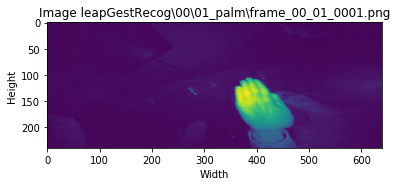

In [9]:
#Example image plot
#Plotting the first image from the dataset
img_plot(imagepaths[0])

In [35]:
#### Creating Training Set and Labels ####
# X for image data
X = []
# y for the labels
y = []

#Load the images into X by doing the necessary conversions and resizing of images
#Resizing is done to reduce the size of image to increase the speed of training
for path in imagepaths[:19999]:
    #print(path)
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    X.append(img)  
    #Getting the labels from the image path
    path= os.path.normpath(path)
    
    #a = path.split("/")
#     print(a)
    category = path.split(os.sep)[2]
#     print(category)
    label = int(category.split("_")[0][1])
    #print(label)
    y.append(label)

#print(label)
#Turning X & y into numpy arrays
X = np.array(X)
X = X.reshape(len(imagepaths[:19999]), 128, 128, 1)
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) #To debug

Images loaded:  19999
Labels loaded:  19999
1 leapGestRecog\00\01_palm\frame_00_01_0001.png


In [36]:
# Make the test train split
threshold = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = threshold, random_state = 42)

In [37]:
# Create a CNN Sequential Model
model = Sequential()
model.add(Conv2D(32, (5,5), activation = 'relu', input_shape=(128,128,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [38]:
#Model configuration for training purpose
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, 
         validation_data=(X_test, y_test))


Train on 13999 samples, validate on 6000 samples
Epoch 1/5
 - 23s - loss: 0.5859 - accuracy: 0.8853 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 2/5
 - 19s - loss: 0.0239 - accuracy: 0.9925 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 3/5
 - 19s - loss: 0.0186 - accuracy: 0.9949 - val_loss: 0.0086 - val_accuracy: 0.9963
Epoch 4/5
 - 19s - loss: 0.0124 - accuracy: 0.9968 - val_loss: 1.6872e-04 - val_accuracy: 1.0000
Epoch 5/5
 - 19s - loss: 0.0062 - accuracy: 0.9985 - val_loss: 6.3480e-05 - val_accuracy: 1.0000


In [40]:
model.save('handgesturerecog_model.h5')

In [41]:
#calculate loss and accuracy on test data

tLoss, tAccuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(tAccuracy*100))

6000/6000 [==============================] - 3s 517us/step
Test accuracy: 100.00%


In [43]:
# Making predictions on test data
prediction = model.predict(X_test)

In [44]:
#Lets compare the predicted value with actual label value
# Ideally both prediction[0] and y_test[0] should be same
np.argmax(prediction[0]), y_test[0]

(4, 4)

In [45]:
def validate_gestures(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (Actual: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

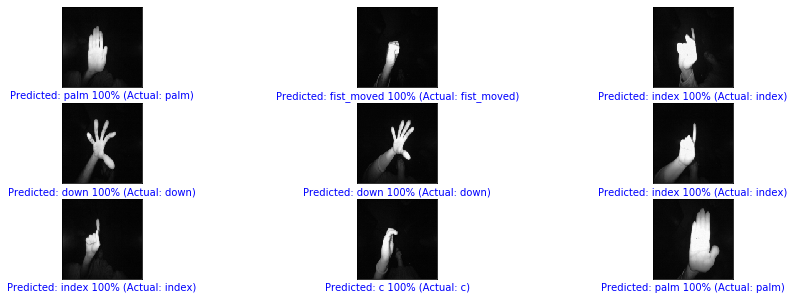

In [46]:
# Plot testing based on predictions and their actual values
validate_gestures(prediction, y_test, X_test)

In [47]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('handgesturerecog_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)      